In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

import plotly.express as px


Data Pre-processing and EDA(Exploratory data analysis)

In [2]:
pd.set_option('display.max_columns', None)

Data Cleaning and filtering data which has firesize <5000 as number of small fires are high.

In [3]:
# Reading the combined CSV files
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['fire_name','Unnamed: 0', 'Unnamed: 0.1','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')

#Get rid of outliers - fires of size larger than 5000 acres, and there are large number of small fires and other very less number are having the high 
# area of fires, because of which the deviation is very high
df = df.loc[df['fire_size'] < 5000]
df.columns

Index(['fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude',
       'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [4]:
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)


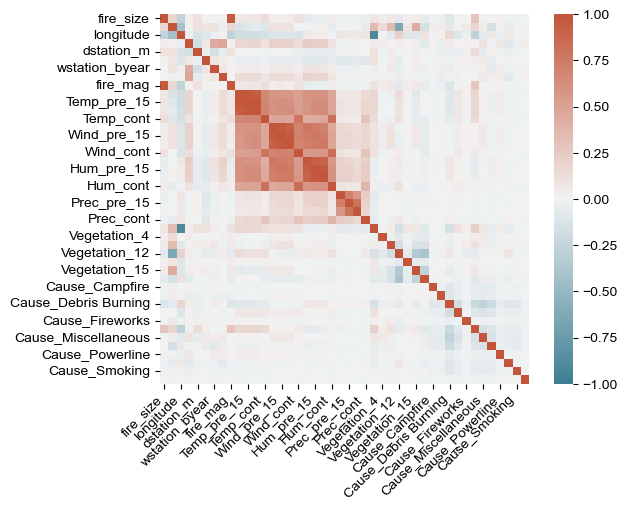

In [5]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,16)})

In [6]:
### Dealing with missing data
print(len(df))

# drop columns where weather_file is missing in the data, as it wont have the weather situation at that time, so its where ever data is 
#missing we can remove those rows as it wont be useful
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

51395
37915


In [7]:
# Weather data has a lot of 0 and values some of which may be missing values,
# Mark '0' values in weather columns as Na (to see how many there are) 
# As 0 wont add any value to the data, we are converting to NA and then removing them which will make data set
subset0 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset0] = df[subset0].replace({0:np.nan, '0':np.nan})
print(len(df))

# Mark '-1' as missing
subset_neg1 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont',])
print(len(df))
# This leaves us with 38,689 observations  +/- 3,000  to work with (originally we had 50,000)

37915
35683


In [8]:
# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill NAs in the date of fire containment based on mean values from previous days
for col in ['Temp','Wind','Hum']:
    df[f'{col}_cont'] = df.apply(
        lambda row: (row[f'{col}_pre_7']+row[f'{col}_pre_15']+row[f'{col}_pre_30'])/3 if np.isnan(row[f'{col}_cont']) else row[f'{col}_cont'],
        axis=1)

In [9]:
df_numerics_only

,fire_size,latitude,longitude,disc_pre_year,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16,Cause_Campfire,Cause_Children,Cause_Debris Burning,Cause_Equipment Use,Cause_Fireworks,Cause_Lightning,Cause_Miscellaneous,Cause_Missing/Undefined,Cause_Powerline,Cause_Railroad,Cause_Smoking,Cause_Structure
0,10.0,18.105072,-66.753044,2007,58917.69716,11603,1945,2018,1.0,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.0,35.038330,-87.610000,2006,32665.34327,13896,1978,2020,0.1,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60.0,34.947800,-88.722500,2004,105122.14950,13896,1978,2020,1.0,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,39.641400,-119.308300,2005,43433.32978,23185,1942,2020,0.1,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2.0,30.700600,-90.591400,1999,25940.57409,3908,1987,2016,0.1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55356,4336.0,34.316000,-112.268300,2015,39824.76795,23184,1946,2020,50.0,23.350785,23.093421,24.573373,24.465102,3.351969,2.970263,2.924852,3.193614,45.053836,46.349030,40.786982,49.818887,86.9,78.8,6.9,41.0,0.192487,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
55357,4856.0,29.616667,-94.273333,2015,22333.66929,99999,1988,2020,50.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.548644,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
55359,3500.0,37.678611,-96.249722,2015,71289.72904,141,2008,2018,50.0,4.040390,10.079851,10.792415,14.275880,3.748422,3.371681,3.712774,4.053697,65.333170,65.610338,68.433839,67.544737,0.0,0.0,0.0,0.0,0.366712,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
55360,3500.0,37.606667,-96.422500,2015,71869.17555,99999,1973,2020,50.0,3.686132,3.039857,4.437563,-0.052527,5.100510,5.694737,4.975000,4.559206,62.971774,69.376658,68.118919,64.008028,20.1,18.8,0.0,3.8,0.365622,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [10]:
#grabFiresizeCorrelations = df_numerics_only[0,:]
#print(grabFiresizeCorrelations)

In [11]:
#grabFiresizeCorrelations = df_numerics_only[0,:]
#print(grabFiresizeCorrelations)
#mapFeature =  {}
#for i in range(len(grabFiresizeCorrelations)):
#    if(not i in mapFeature.keys()):
#        mapFeature[i]= grabFiresizeCorrelations[i]
#    else:
#        print("rip")
#print(mapFeature)


In [12]:
#https://www.fs.usda.gov/about-agency/contact-us/regional-offices
#https://www.latlong.net/
#[ top left, bottom left, bottom right top right]
def createRegionDF(coords,regionName,regionDF):
    coords = [ (coord[0],coord[1],regionName) for coord in coords]
    if(len(regionDF)==0 ):
        regionDF = pd.DataFrame(data= coords, index=None, columns=["lat","lon","region"] )
    else:
        newRegionDF = pd.DataFrame(data= coords, index=None, columns=["lat","lon","region"] )
        regionDF = pd.concat([regionDF,newRegionDF],axis=0)
    return regionDF
region1_coordinates = [(48.998625,-117.032181),(45.424841, -116.575238), (45.548077, -114.563236),(45.458889, -114.340904),(45.702748,-113.970683),(44.355692,-112.842069),(44.501816, -112.716047),(44.446140,-112.386114),(44.536460, -112.353637) ,(44.562305,-111.868789),(44.541651,-111.463793),(44.752791,-111.382034),(44.476095, -111.052484),(45.000642, -111.054512),(44.997898,-104.039652),(45.945135, -104.045442),(45.935240, -96.563685),(49.000315,-97.238073)]
region2_coordinates = [(44.476095, -111.052484),(44.476095,-110.001004),(44.159549,-109.050031),(41.000701,-109.050031),(36.998911, -109.045210),(36.689620,-109.045210),(36.689620,-103.002242),(37.000070,-103.002242),(37.000070,-94.617957),(39.101825,-94.617957),(42.435240, -96.420416),(45.301939, -96.420416),(45.604551, -96.855765),(45.935240, -96.563685),(45.00064,111.0545),(44.9979,104.0397),(45.94519,104.0454),(45.000642, -111.054512),(44.997898,-104.039652),(45.945135, -104.045442),(45.935240, -96.563685)]
region3_coordinates = [(36.689620,-114.050103) ,(36.195716,-114.050103),(36.023904,-114.152134),(36.095684,-114.748691),(35.001852,-114.633024),(34.876637,-114.635455),(34.715618,-114.486139),(34.466089,-114.402030),(34.302181,-114.138016),(34.258653,-114.132248),(34.095316,-114.422722),(33.933782,-114.535904),(33.347272,-114.698987),(33.289786,-114.726255),(33.071656,-114.687490),(32.974216,-114.472487),(32.844382,-114.469185),(32.718194,-114.719968),(32.493855,-114.813498),(31.332248,-111.074822),(31.332248,-108.208456),(31.783597,-108.208456),(31.783597,-106.527977),(31.897016,-106.645840),(32.000679,-106.645840),(32.000379,-103.064510) ,(36.689620,-109.045210),(36.689620,-103.002242)]
region4_coordinates = [(45.424841, -116.575238), (45.548077, -114.563236),(45.458889, -114.340904),(45.702748,-113.970683),(44.355692,-112.842069),(44.501816, -112.716047),(44.446140,-112.386114),(44.536460, -112.353637) ,(44.562305,-111.868789),(44.541651,-111.463793),(44.752791,-111.382034),(44.476095, -111.052484),(44.476095,-110.001004),(44.159549,-109.050031),(41.000701,-109.050031),(36.998911, -109.045210),(36.689620,-109.045210),(36.689620,-114.050103) ,(36.195716,-114.050103),(36.023904,-114.152134),(36.095684,-114.748691),(35.001852,-114.633024)   ,(38.999594,-120.001012) ,(41.994873,-120.001012) ,(41.994873,-117.026266) ]
region5_coordinates = [(35.001852,-114.633024),(34.876637,-114.635455),(34.715618,-114.486139),(34.466089,-114.402030),(34.302181,-114.138016),(34.258653,-114.132248),(34.095316,-114.422722),(33.933782,-114.535904),(33.347272,-114.698987),(33.289786,-114.726255),(33.071656,-114.687490),(32.974216,-114.472487),(32.844382,-114.469185),(32.718194,-114.719968),(38.999594,-120.001012),(41.994873,-120.001012),(32.515552,-117.235491),(34.243595,-120.939332),(40.338170,-124.717891),(41.99487,-124.598449) ]     
region6_coordinates=[(48.407326,-125.003417),(48.380882,-123.134889),(48.999592,-123.320267),(48.999099,-117.032380),(41.99487,-124.598449),(41.994873,-120.001012),(41.99487,-117.0263),(45.4284,-116.5752),(48.99863,-117.0322)]
region8_coordinates = [(36.689620,-103.002242),(31.332248,-108.208456),(31.783597,-108.208456),(31.783597,-106.527977),(31.897016,-106.645840),(32.000679,-106.645840),(32.000379,-103.064510),(37.000070,-103.002242),(37.000070,-94.617957),(36.499488,-94.617874), (36.484245,-90.159248),(35.994952,-90.375636), (36.000941,-89.706940), (36.974033,-89.137409), (37.145540,-89.089624), (37.219940,-88.948239), (37.067780,-88.554268), (37.087364,-88.448597), (37.205586,-88.450610), (37.290170,-88.512708), (37.423889,-88.409754), (37.400437,-88.368572), (37.469136,-88.095988), (37.495290,-88.062357), (37.673767,-88.146777), (37.924024,-87.904758), (38.854681,-84.793704), (39.105022,-84.487693), (38.781922,-84.216453), (38.717662,-82.882168), (38.415938,-82.590182), (38.146438,-82.639409), (37.620758,-82.348588), (37.103932,-81.727357), (37.447606,-80.304973), (38.451438,-79.228965), (39.270537,-78.389899), (39.680769,-78.173912), (39.331111,-77.762201), (39.216295,-77.465616), (39.120472,-77.528761) , (38.874998,-77.042818), (38.399797,-77.312423), (37.881357,-76.252680), (37.983175,-74.876576),(36.888408,-75.589566),(35.146863,-75.172259),(31.306715,-80.882779),(27.000408,-79.896863),(24.507143,-80.555769),(28.902397,-84.904550),(28.709861,-89.345415),(28.478349,-95.187717),(25.943227,-96.910542),(26.357420,-99.119591),(29.621221,-101.513572),(28.912015,-103.138874),(30.073848,-104.830540)]#
region9_coordinates = [(37.000070,-94.617957),(39.101825,-94.617957),(42.435240, -96.420416),(45.301939, -96.420416),(45.604551, -96.855765),(45.935240, -96.563685),(36.499488,-94.617874), (36.484245,-90.159248),(35.994952,-90.375636), (36.000941,-89.706940), (36.974033,-89.137409), (37.145540,-89.089624), (37.219940,-88.948239), (37.067780,-88.554268), (37.087364,-88.448597), (37.205586,-88.450610), (37.290170,-88.512708), (37.423889,-88.409754), (37.400437,-88.368572), (37.469136,-88.095988), (37.495290,-88.062357), (37.673767,-88.146777), (37.924024,-87.904758), (38.854681,-84.793704), (39.105022,-84.487693), (38.781922,-84.216453), (38.717662,-82.882168), (38.415938,-82.590182), (38.146438,-82.639409), (37.620758,-82.348588), (37.103932,-81.727357), (37.447606,-80.304973), (38.451438,-79.228965), (39.270537,-78.389899), (39.680769,-78.173912), (39.331111,-77.762201), (39.216295,-77.465616), (39.120472,-77.528761) , (38.874998,-77.042818), (38.399797,-77.312423), (37.881357,-76.252680), (37.983175,-74.876576),(49.00032,-97.23807),(49.368066,-94.978894),(46.483265,-84.392468),(44.071800,-82.152187),(41.656497,-82.635385),(44.918139,-74.948146),(47.323931,-69.237625),(47.234490,-68.079804),(44.543505,-66.937208),(40.896906,-69.484978)]
region10_coordinates = [(70.641769,-166.837630),(65.594800,-168.271506),(60.053874,-167.876564),(57.715885,-159.793981),(57.868132,-158.483863),(52.133488,-177.723924),(53.357109,-187.651444),(55.751849,-193.449818),(55.553495,-194.679777),(54.546580,-194.416214),(51.481383,-186.333632),(50.541363,-176.230403),(59.063154,-143.548657),(54.431713,-133.649274),(55.216490,-129.871545),(59.745326,-135.401178),(58.893296,-137.377897),(60.307906,-140.988369),(69.885010,-140.718507)]

regionDF = createRegionDF(region1_coordinates,1,pd.DataFrame())
regionDF = createRegionDF(region2_coordinates,2,regionDF)
regionDF = createRegionDF(region3_coordinates,3,regionDF)
regionDF = createRegionDF(region4_coordinates,4,regionDF)
regionDF = createRegionDF(region5_coordinates,5,regionDF)
regionDF = createRegionDF(region6_coordinates,6,regionDF)
regionDF = createRegionDF(region8_coordinates,8,regionDF)
regionDF = createRegionDF(region9_coordinates,9,regionDF)
regionDF = createRegionDF(region10_coordinates,10,regionDF)

print("Regions in Dataframe ",regionDF["region"].unique())

Regions in Dataframe  [ 1  2  3  4  5  6  8  9 10]


In [13]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
 
def checkIfCoordInRegion(regionName,regionDF,df):#reference: https://stackoverflow.com/questions/61042261/how-to-check-if-a-lat-lon-coordinate-is-within-a-polygon-using-python-taking
    polygon = Polygon([tuple(x) for x in regionDF[['lat', 'lon']].to_numpy()])
    df[f'Within_{regionName}'] = df.apply(lambda x: polygon.contains(Point(x['latitude'], x['longitude'])), axis=1)
    return df


for i in range(1,11):
    if(i!=7):
        df = checkIfCoordInRegion(f"Region{i}",regionDF[regionDF["region"]==i],df)

In [14]:
region1Coord_test =df[df["state"]== "CA"][0:15][["latitude","longitude","Within_Region1","Within_Region2","Within_Region5"]]
print(region1Coord_test)

      latitude   longitude  Within_Region1  Within_Region2  Within_Region5
78   34.330000 -117.513056           False           False           False
88   35.298056 -120.480000           False           False            True
123  36.060200 -118.096500           False           False           False
159  39.965000 -122.318056           False           False            True
192  40.228611 -120.671389           False           False           False
267  36.568867 -119.481683           False           False            True
274  33.504110 -116.379500           False           False           False
302  32.853056 -116.885000           False           False           False
308  39.951177 -122.200397           False           False            True
309  37.113056 -120.346944           False           False            True
312  35.928294 -119.312886           False           False            True
394  37.323889 -120.550000           False           False            True
436  37.265000 -120.18805

In [15]:
def regionNum(x):
    #print(x)
    if(x['state']=='HI'):
        return 5
    else:
        #print(x[["LATITUDE","LONGITUDE","STATE"]])
        listRegion = list(x[["Within_Region1","Within_Region2","Within_Region3","Within_Region4","Within_Region5","Within_Region6","Within_Region8","Within_Region9","Within_Region10"]])
        #print(istRegion)
        if(np.sum(listRegion)!=1):
                return -1
        if(x["Within_Region1"]):
            return 1
        if(x["Within_Region2"]):
            return 2
        if(x["Within_Region3"]):
            return 3
        if(x["Within_Region4"]):
            return 4
        if(x["Within_Region5"]):
            return 5
        if(x["Within_Region6"]):
            return 6
        if(x["Within_Region8"]):
            return 8
        if(x["Within_Region9"]):
            return 9
        if(x["Within_Region10"]):
            return 10
def reformatRegionClassification(df):
    df["Region"] = df.apply( lambda x: regionNum(x), axis=1)
    return df
df = reformatRegionClassification(df)

In [16]:
print("incorrect",df[df["Region"]== -1].size)
print("correct",df[df["Region"]!= -1].size)
print("Total",df.size)

incorrect 240093
correct 2007936
Total 2248029


This mean 243904 are not correct out of  and need to be removed/corrected. Region boundaries as mentioned in the other notebook will force us to exclude those corresponding states.

In [17]:
statesLeft = df[df["Region"]==-1]["state"].unique()
overlapStates = ['OK','WY','ID','PR']
for i in range(len(overlapStates)):
    statesLeft=statesLeft[statesLeft != overlapStates[i]]
print("States with overlap:", overlapStates)

States with overlap: ['OK', 'WY', 'ID', 'PR']


In [18]:
def adjustDf(df):
    print(f"Before adjustments there are ",df[df["Region"]== -1].size ," rows classified incorrectly") 

    #will go by state(assuming no overlap within state with region) to classify 
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'MT') , 1, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'SD') , 2, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'KS') , 2, df['Region'])

    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'AZ') , 3, df['Region'])

    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'NM') , 4, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'NV') , 4, df['Region'])


    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'CA') , 5, df['Region'])

    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'WA') , 6, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'OR') , 6, df['Region'])

    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'TX') , 8, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'FL') , 8, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'KY') , 8, df['Region'])

    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'NJ') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'MD') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'WV') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'DE') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'PA') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'NY') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'MN') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'MO') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'IN') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'IL') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'WI') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'MI') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'OH') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'ME') , 9, df['Region'])
    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'IA') , 9, df['Region'])

    df['Region'] = np.where((df['Region'] ==-1) & (df['state'] == 'AK') , 10, df['Region'])

    #rest of them to a region else will be dropped from the DS
    print("After adjustments: ",df[df["Region"]== -1].size, " --these rows will be dropped from the df")
    #df = df[df['Region'] != -1]
    print("Final count of misclassified fire regions: ",df[df["Region"]== -1].size)
    return df

In [19]:
df = df.drop(["Within_Region1","Within_Region2","Within_Region3","Within_Region4","Within_Region5","Within_Region6","Within_Region8","Within_Region9","Within_Region10"], axis='columns')

Creating a database that just has the correctly labeled regions **df_removed**:"labels with -1 were removed". Will use to compare with **df_adjusted**: "using states with no overlap to adjust incorrect labels and drop ones that are left".

In [20]:
df_removed = df[df["Region"]!= -1].copy()
df_adjusted = df.copy()
df_adjusted = adjustDf(df_adjusted)

Before adjustments there are  205794  rows classified incorrectly
After adjustments:  22950  --these rows will be dropped from the df
Final count of misclassified fire regions:  22950


Removing all outlier rows from fire size

In [21]:
def dropOutliers(dfTemp,fireSizeThreshold):#taken from pre-processing notebook created by duy
    df= dfTemp.copy()
    # Pre-processing min, max, median, std, IQR
    df_fire_size = df['fire_size']
    # Number of objects
    numObj = df_fire_size.count()
    print('count', numObj)
    # The minimum value
    minValue = df_fire_size.min()
    print('min', minValue)
    # The maximum value
    maxValue = df_fire_size.max()
    print('max', maxValue)
    # The mean value
    mean = df_fire_size.mean()
    print('mean', mean)
    # The standard deviation value
    stdev = df_fire_size.std()
    print('std', stdev)
    # The Q1 value
    Q1 = df_fire_size.quantile(1 / 4)
    print('Q1', Q1)
    # The median value
    median = df_fire_size.median()
    print('median', median)
    # The Q3 value
    Q3 = df_fire_size.quantile(3/4)
    print('Q3', Q3)
    # The IQR value
    IQR = Q3 - Q1
    print('IQR', IQR)
    
    #df_fire_size = (df.loc[df['fire_size'] < fireSizeThreshold])['fire_size']
    
    df = df.drop(df[df['fire_size'] >= fireSizeThreshold].index)
    df_fire_size = df['fire_size']
    # Number of objects
    numObj = df_fire_size.count()
    print('count', numObj)
    # The minimum value
    minValue = df_fire_size.min()
    print('min', minValue)
    # The maximum value
    maxValue = df_fire_size.max()
    print('max', maxValue)
    # The mean value
    mean = df_fire_size.mean()
    print('mean', mean)
    # The standard deviation value
    stdev = df_fire_size.std()
    print('std', stdev)
    # The Q1 value
    Q1 = df_fire_size.quantile(1 / 4)
    print('Q1', Q1)
    # The median value
    median = df_fire_size.median()
    print('median', median)
    # The Q3 value
    Q3 = df_fire_size.quantile(3/4)
    print('Q3', Q3)
    # The IQR value
    IQR = Q3 - Q1
    print('IQR', IQR)
    return df

In [22]:
df_adjusted = dropOutliers(df_adjusted,3.5)

count 35683
min 0.51
max 4994.0
mean 165.51327134657964
std 728.6857104261225
Q1 1.0
median 3.0
Q3 12.0
IQR 11.0
count 18888
min 0.51
max 3.49
mean 1.5604484619864465
std 0.7415684499230748
Q1 1.0
median 1.0
Q3 2.0
IQR 1.0


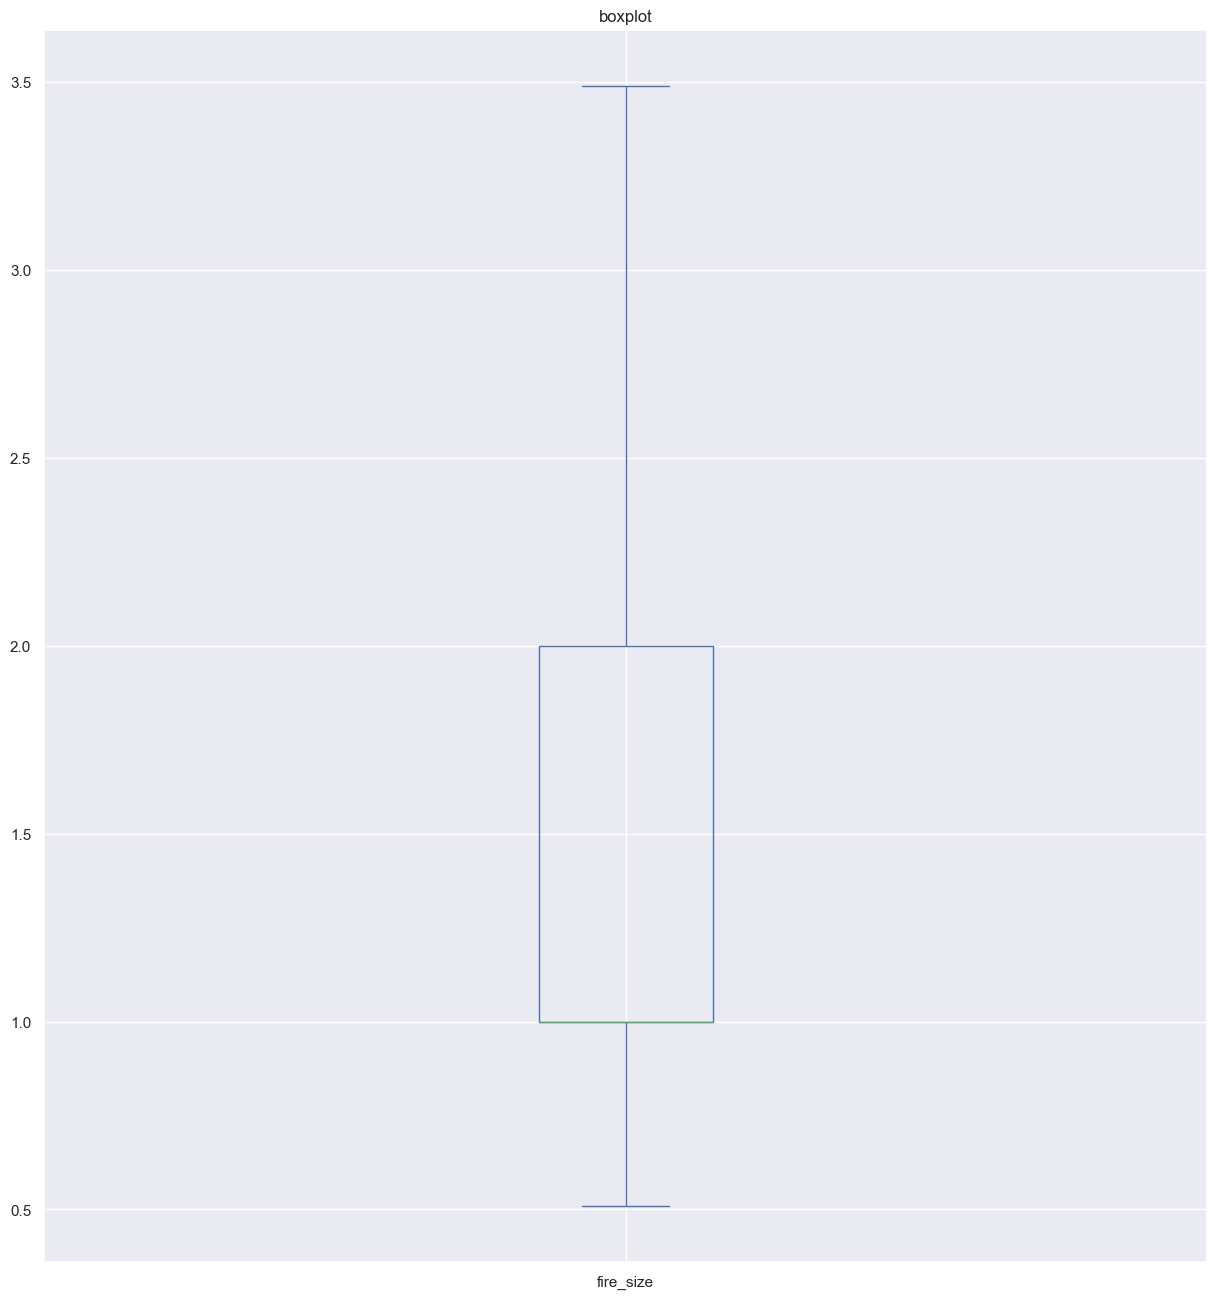

In [23]:
ax = df_adjusted["fire_size"].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

In [24]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)

In [25]:
class dfByRegion():
    df_r1 = None
    df_r2 = None
    df_r3 = None
    df_r4 = None
    df_r5 = None
    df_r6 = None
    df_r8 = None
    df_r9 = None
    df_r10 = None
    df=None
    dfList = []
    def __init__(self,df):
        self.df = df
        self.splitdf()
        self.dfList = [self.df_r1,self.df_r2,self.df_r3,self.df_r4,self.df_r5,self.df_r6,self.df_r8,self.df_r9,self.df_r10]
    def splitdf(self):
        self.df_r1 = self.df[self.df["Region"]==1]
        self.df_r2 = self.df[self.df["Region"]==2]
        self.df_r3= self.df[self.df["Region"]==3]
        self.df_r4 = self.df[self.df["Region"]==4]
        self.df_r5 = self.df[self.df["Region"]==5]
        self.df_r6 = self.df[self.df["Region"]==6]
        self.df_r8 = self.df[self.df["Region"]==8]
        self.df_r9 = self.df[self.df["Region"]==9]
        self.df_r10 = self.df[self.df["Region"]==10]
    def printSize(self):
        for i in range(len(self.dfList)):
            df_temp= self.dfList[i]
            region = i+1
            if(region >=7):
                region +=1
            print(f"dfRegion{(region)} size: {df_temp.size}")
    

In [26]:
print("df_adjusted sizes below")
print("________________________")
df_adjusted_ByRegion = dfByRegion(df_adjusted)   
df_adjusted_ByRegion.printSize()
print("")
print("df_removed sizes below")
print("________________________")
df_removed_ByRegion = dfByRegion(df_removed)  
df_removed_ByRegion.printSize()

df_adjusted sizes below
________________________
dfRegion1 size: 26406
dfRegion2 size: 42444
dfRegion3 size: 26676
dfRegion4 size: 27000
dfRegion5 size: 84186
dfRegion6 size: 22410
dfRegion8 size: 616302
dfRegion9 size: 155412
dfRegion10 size: 3348

df_removed sizes below
________________________
dfRegion1 size: 55296
dfRegion2 size: 90396
dfRegion3 size: 52542
dfRegion4 size: 58374
dfRegion5 size: 97902
dfRegion6 size: 24732
dfRegion8 size: 1188972
dfRegion9 size: 139536
dfRegion10 size: 13338


In [27]:
df_adjusted_ByRegion.df_r1

,fire_size,fire_size_class,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Cause,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16,Cause_Campfire,Cause_Children,Cause_Debris Burning,Cause_Equipment Use,Cause_Fireworks,Cause_Lightning,Cause_Miscellaneous,Cause_Missing/Undefined,Cause_Powerline,Cause_Railroad,Cause_Smoking,Cause_Structure,Region
9,1.0,B,48.839400,-99.718500,ND,2004-04-19,Apr,3/20/2004,2004,Mar,727675,129109.88140,99999,1936,2020,0.1,727675-99999-2004.gz,4.600950,6.861878,6.053333,5.838721,6.380760,6.334254,6.645333,6.453449,64.606509,55.943038,54.337838,58.295795,12.3,1.8,0.0,0.0,0.291683,Miscellaneous,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
31,1.2,B,48.833000,-99.783600,ND,2007-04-07,Apr,3/8/2007,2007,Mar,727573,102830.03610,99999,2006,2020,0.1,727573-94928-2007.gz,-0.891635,0.372659,-4.273834,-1.597603,5.800667,6.012852,6.658621,6.157380,77.575012,75.963981,71.173116,74.904036,21.2,21.2,9.2,0.0,0.292303,Debris Burning,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
121,1.0,B,45.563900,-107.486800,MT,1995-10-02,Oct,9/2/1995,1995,Sep,726660,97268.92407,24029,1974,1998,0.1,726660-24029-1995.gz,14.047091,9.798333,12.519048,12.121491,2.866445,2.727333,2.600714,2.731498,57.015025,60.878788,53.050000,56.981271,23.0,23.0,0.0,0.0,0.367262,Structure,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
146,1.0,B,46.114400,-100.692300,ND,2001-04-02,Apr,3/3/2001,2001,Mar,726685,66927.03271,94052,1973,2005,0.1,726685-99999-2001.gz,-1.333333,-0.153203,-0.059880,-0.515472,3.925559,4.100279,4.186145,4.070661,76.086455,70.221264,70.062893,72.123538,2.6,2.3,1.3,0.0,0.301475,Debris Burning,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
293,3.0,B,46.811944,-115.344167,ID,2015-08-11,Aug,7/12/2015,2015,Jul,726817,75044.26419,99999,1932,2020,0.1,726817-24154-2015.gz,14.457688,16.473458,15.686047,10.385702,2.107509,2.027473,2.208284,2.248676,49.332061,38.876374,40.508876,60.844641,28.2,3.3,0.3,20.2,0.444898,Lightning,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49771,1.0,B,47.733300,-102.751100,ND,2013-03-21,Mar,2/19/2013,2013,Feb,720868,38338.53811,294,2010,2020,0.1,720868-00294-2013.gz,-6.564629,-7.389306,-8.529058,-7.494331,4.014673,4.341315,4.697194,4.351061,81.350728,80.955122,80.101660,80.802503,0.0,0.0,0.0,0.0,0.320861,Missing/Undefined,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
49835,2.6,B,48.869700,-99.721300,ND,1996-05-22,May,4/22/1996,1996,Apr,727675,130149.87800,99999,1936,2020,0.1,727675-94011-1996.gz,8.063950,10.882271,15.153846,11.366689,5.055370,5.171831,6.012048,5.413083,65.187767,66.545714,71.825301,67.852927,30.1,21.3,9.3,0.0,0.291705,Miscellaneous,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
49874,1.0,B,46.090300,-100.657900,ND,2005-04-24,Apr,3/25/2005,2005,Mar,727640,77376.13311,24011,1973,2010,0.1,727640-24011-2005.gz,9.325227,10.614534,11.837500,10.592420,5.305114,5.750976,5.230000,5.428697,55.461802,58.430131,50.235000,54.708978,50.8,50.8,8.2,0.0,0.301152,Children,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
49909,2.0,B,48.056944,-113.722222,MT,2003-07-01,Jul,6/1/2003,2003,Jun,727790,48763.25960,24146,1973,2020,0.1,727790-24146-2003.gz,16.230082,17.888345,19.136923,17.538849,2.508824,2.766200,2.841538,3.184173,59.455083,55.505828,50.020513,41.928058,72.1,24.5,0.0,0.6,0.428399,Lightning,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


At the moment we will only used the adjusted dataset as we explort the dataset

In [28]:
def createRegionMapBasedOnFireSize(df,regionNum):
    print("- size: ", df.size)
    fig = px.scatter_geo(df,lat='latitude',lon='longitude',
                      size="fire_size",
                      color = "fire_size_class")
    title = f"Region{regionNum} Map of Fires"
    fig.update_layout(title = title,geo_scope='usa', title_x=0.5)
    
    #fig.show()
    #fig.write_image(f"USmapByRegion/USmapFires_Region{regionNum}.png", width=1980, height=1080) #-uncomment to update pictures

In [29]:
print("This can show the most frequent areas of fires over specific region, which could prove useful in predicting...")
for i in range(len(df_adjusted_ByRegion.dfList)):
    regionNum=i+1
    
    if(i>=6):
        regionNum +=1
    print(f"Creating maps of all fires by size: by region {regionNum}")
    dfTemp = df_adjusted_ByRegion.dfList[i]
    createRegionMapBasedOnFireSize(dfTemp,regionNum)
    

This can show the most frequent areas of fires over specific region, which could prove useful in predicting...
Creating maps of all fires by size: by region 1
- size:  26406
Creating maps of all fires by size: by region 2
- size:  42444
Creating maps of all fires by size: by region 3
- size:  26676
Creating maps of all fires by size: by region 4
- size:  27000
Creating maps of all fires by size: by region 5
- size:  84186
Creating maps of all fires by size: by region 6
- size:  22410
Creating maps of all fires by size: by region 8
- size:  616302
Creating maps of all fires by size: by region 9
- size:  155412
Creating maps of all fires by size: by region 10
- size:  3348


   Location Letter     value
0         1      A  0.549647
1         1      A  0.451407
2         1      A  0.303932
3         1      A  0.460961
4         1      A  0.856597


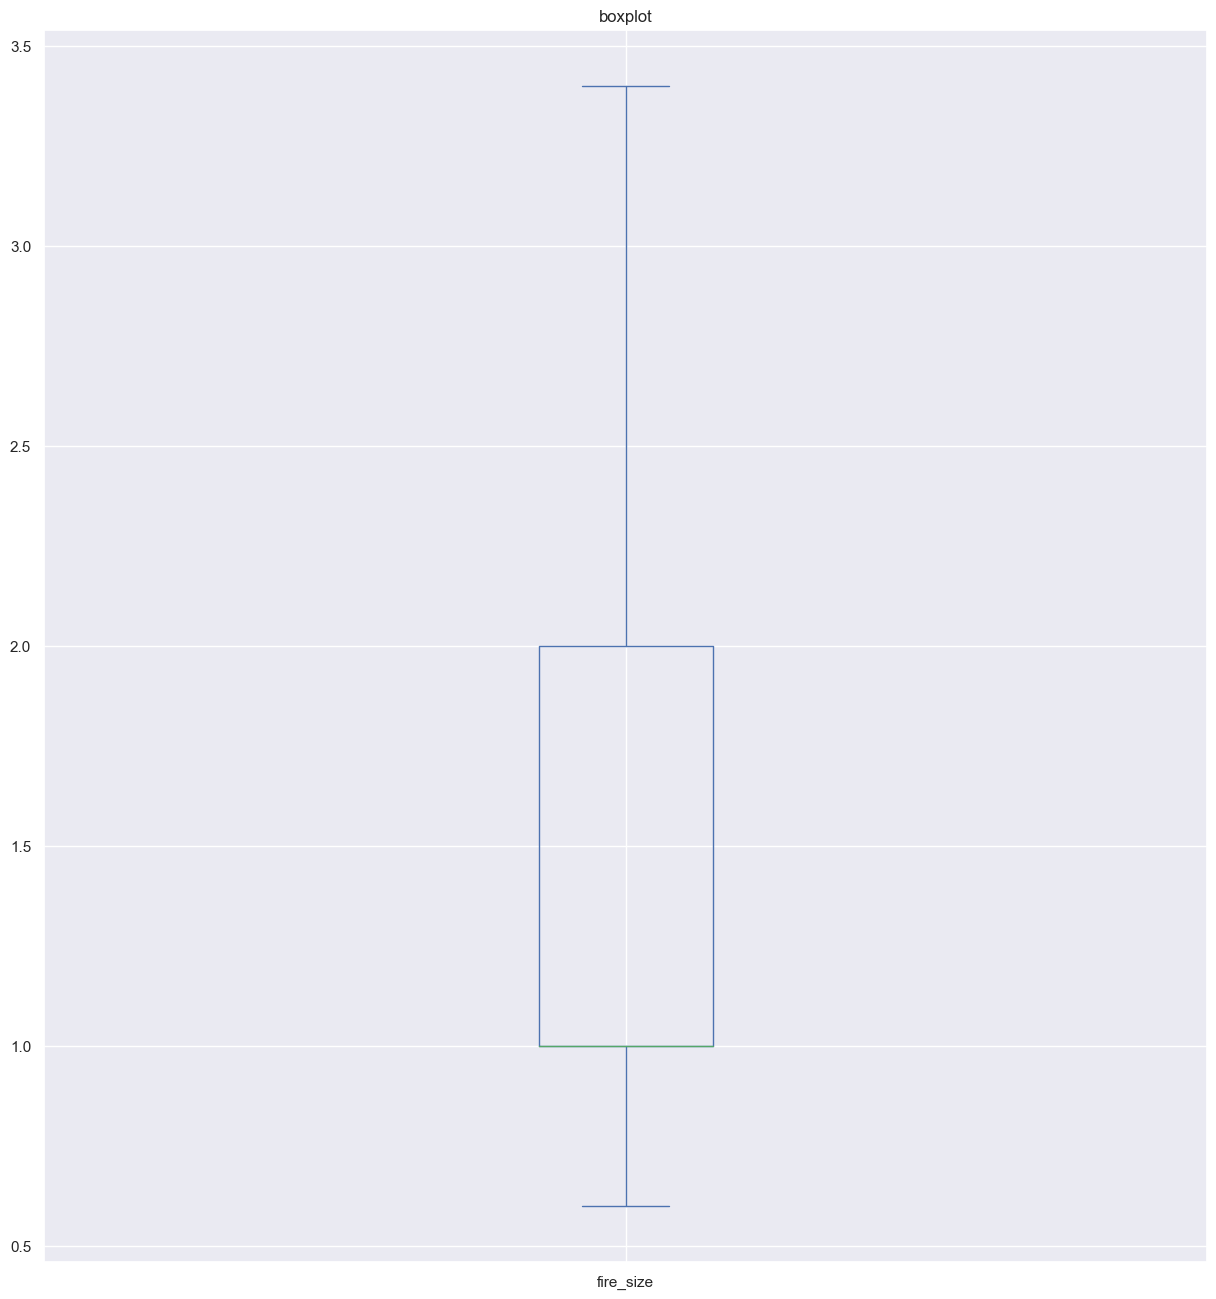

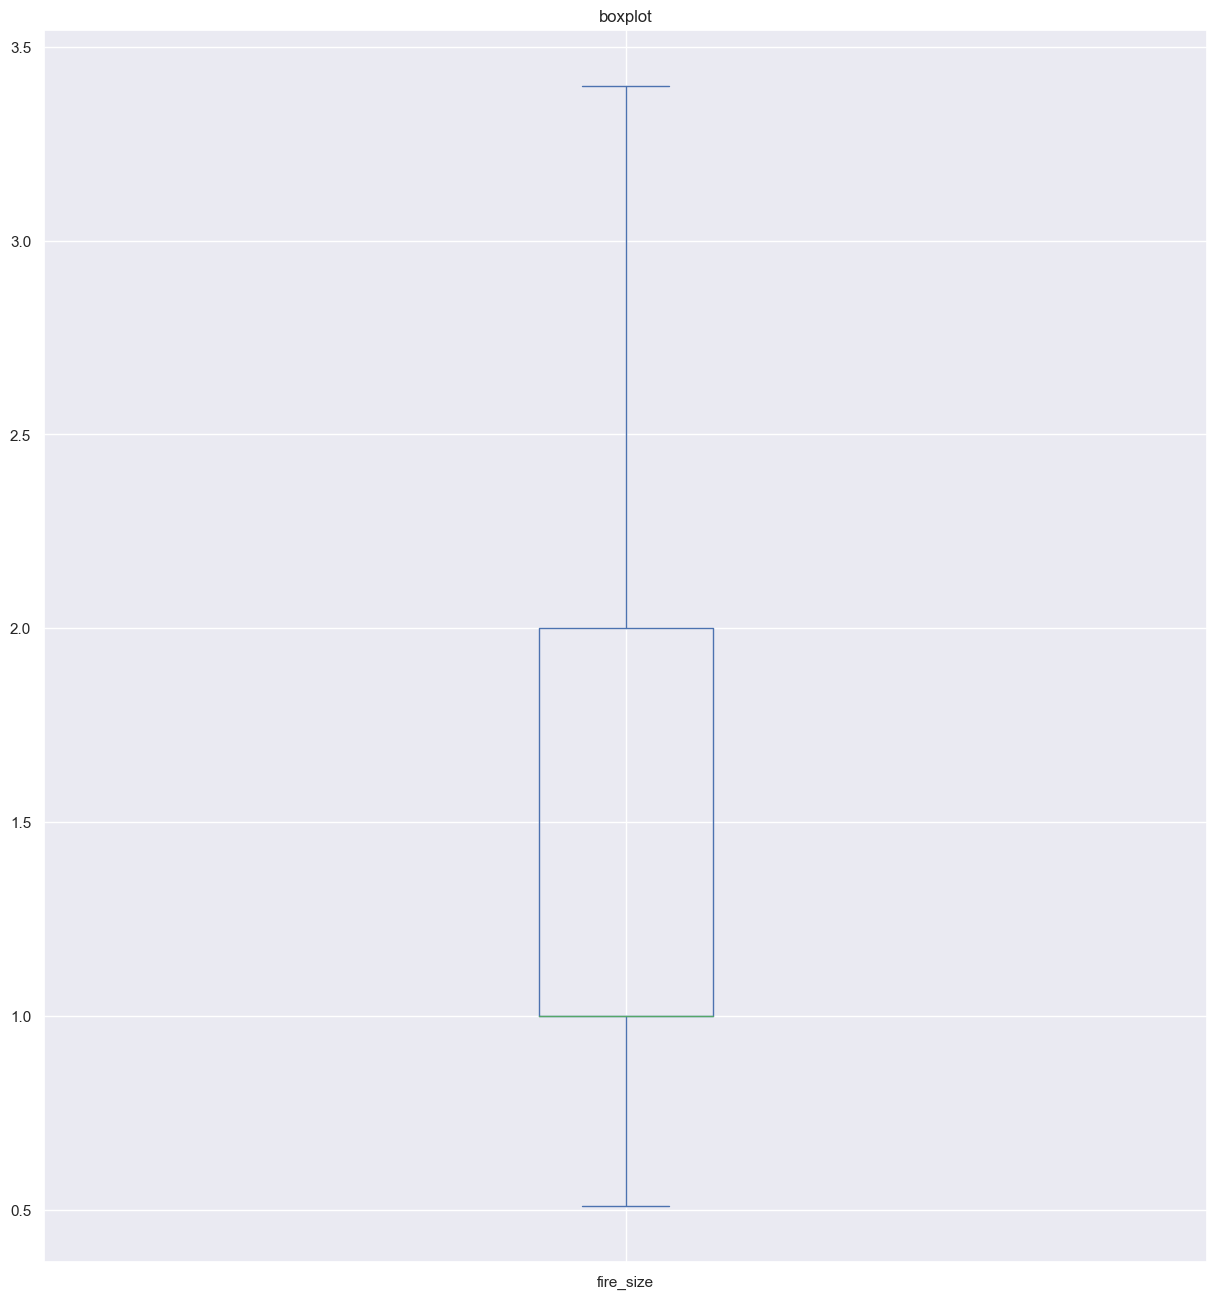

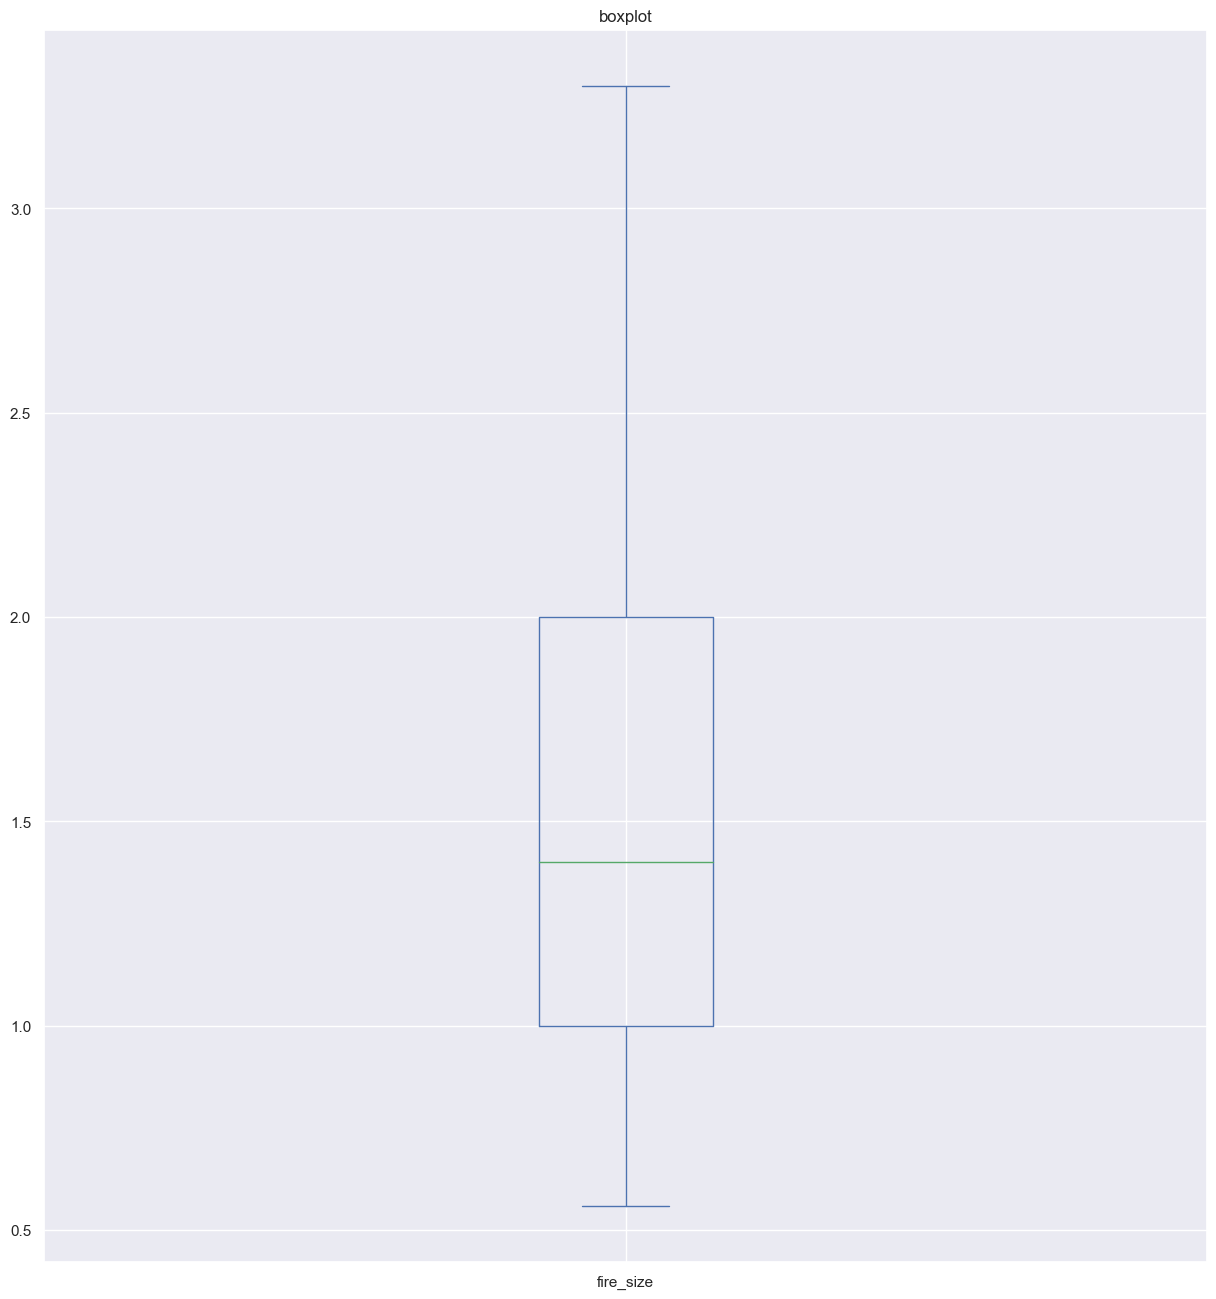

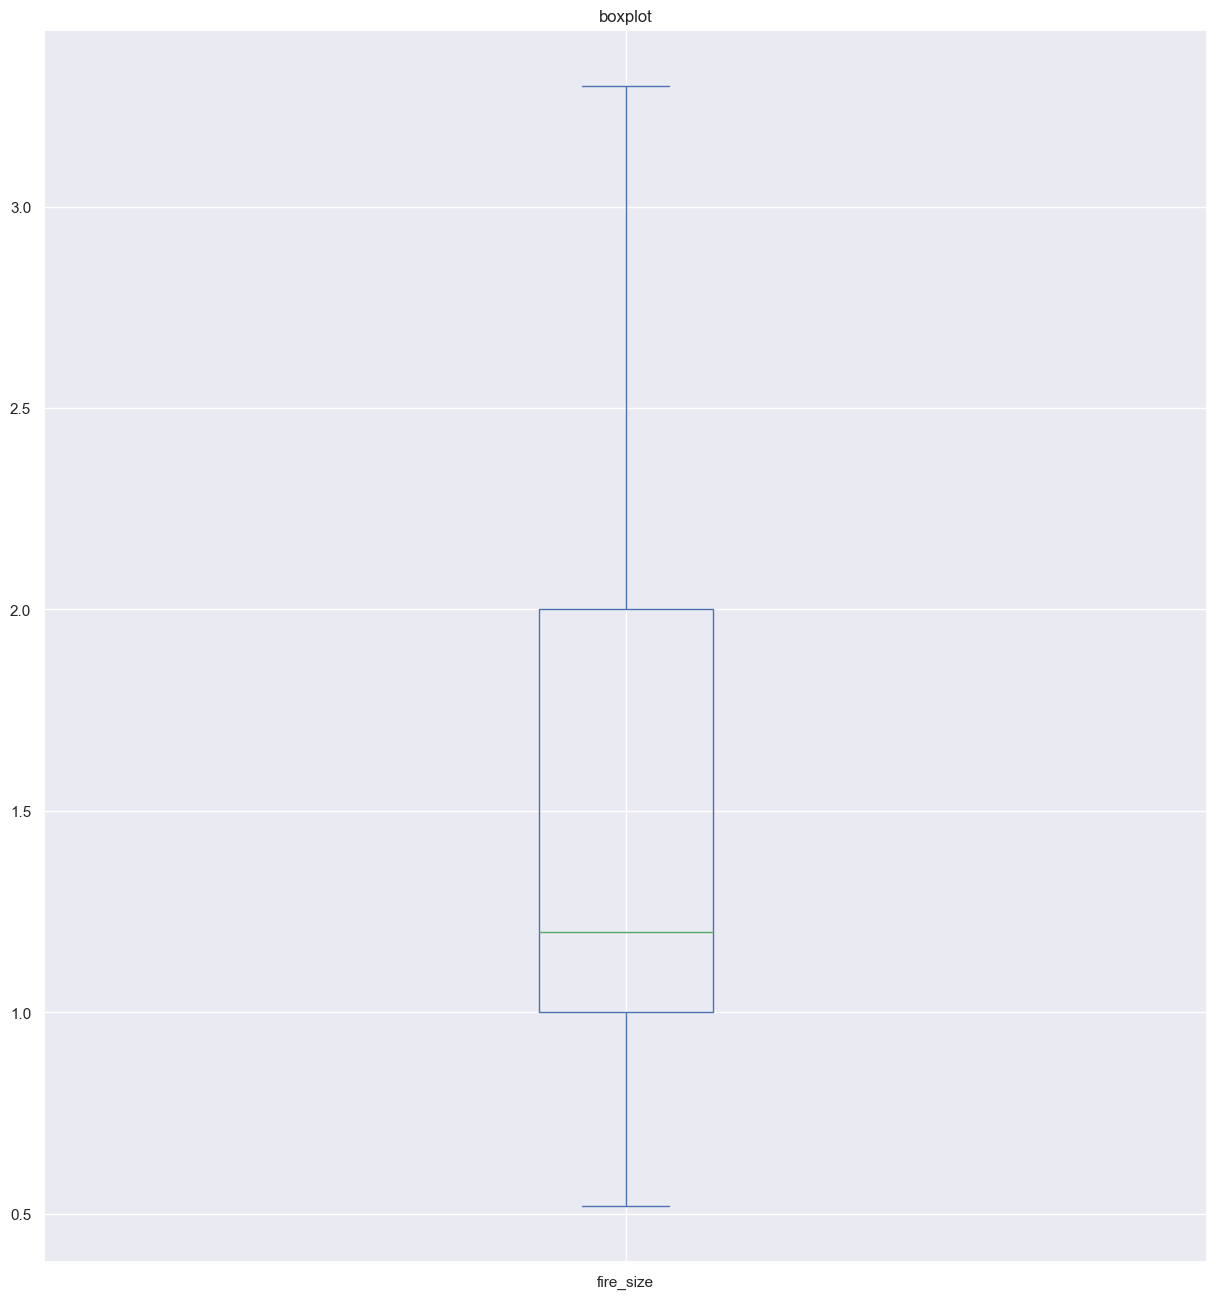

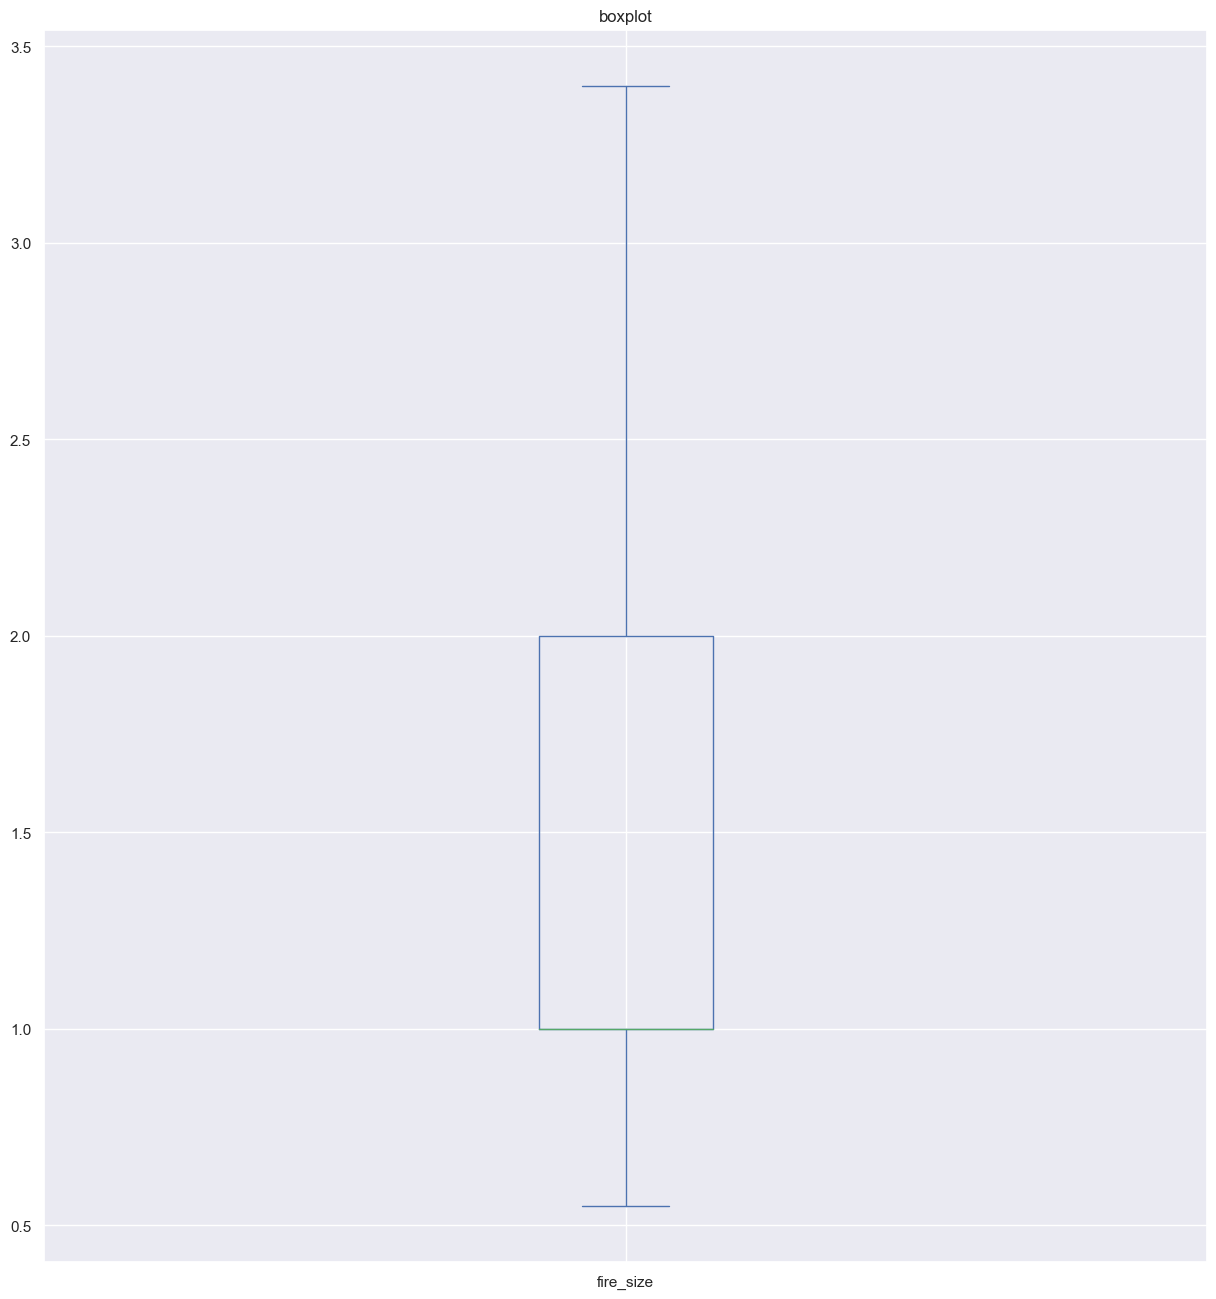

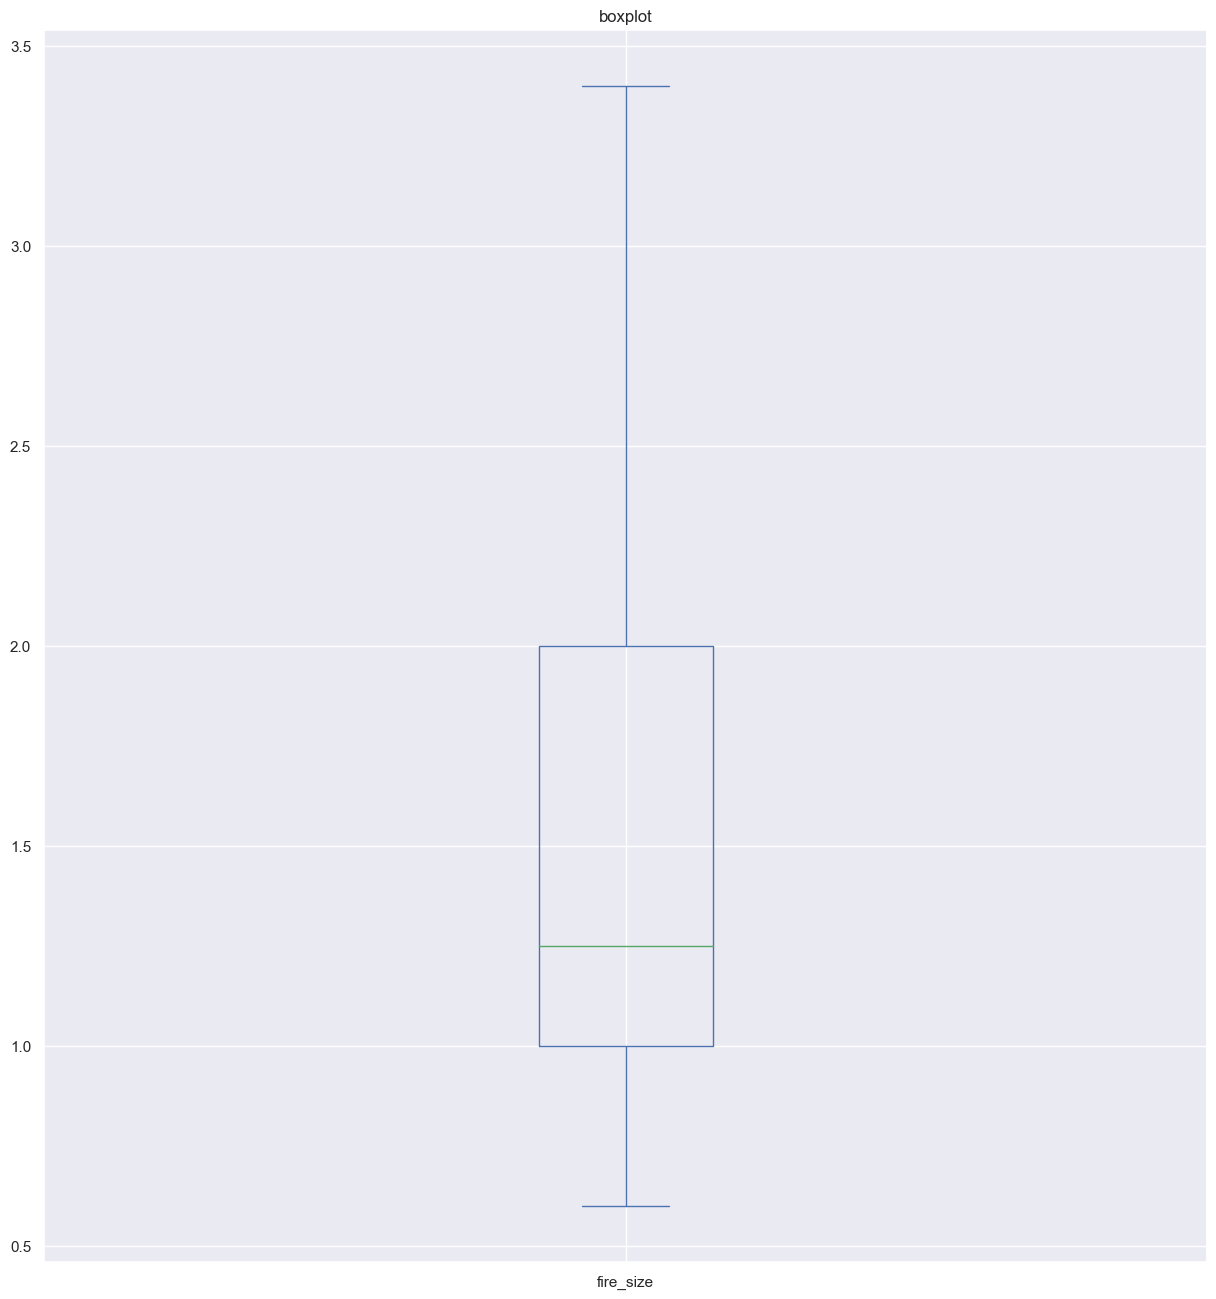

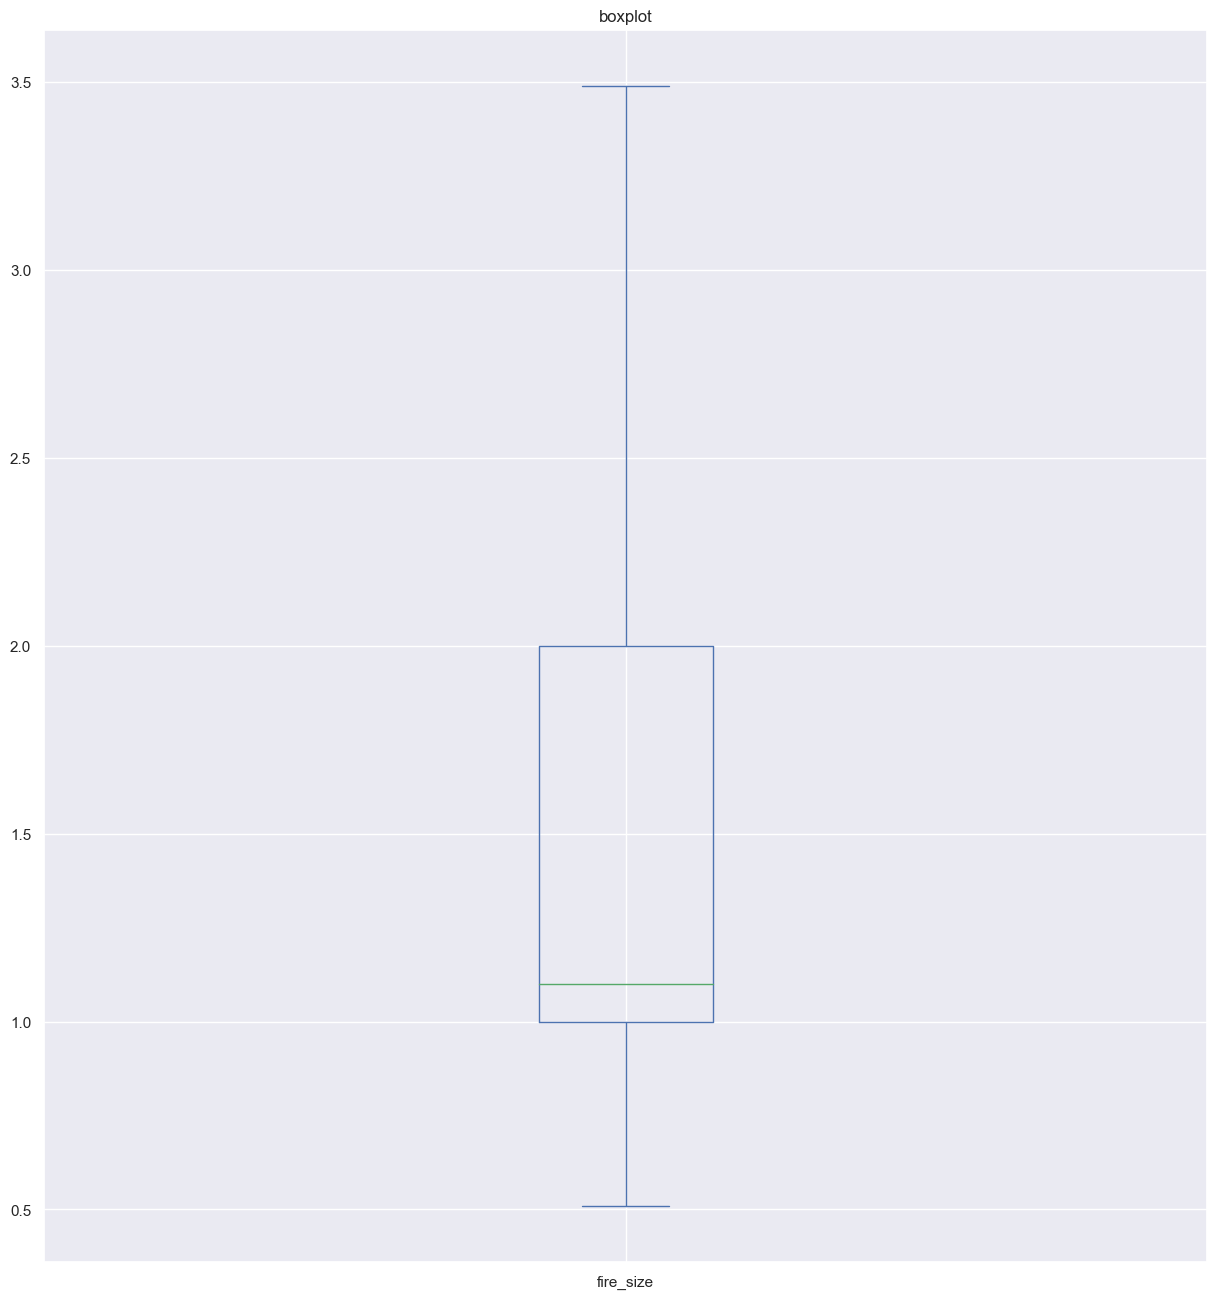

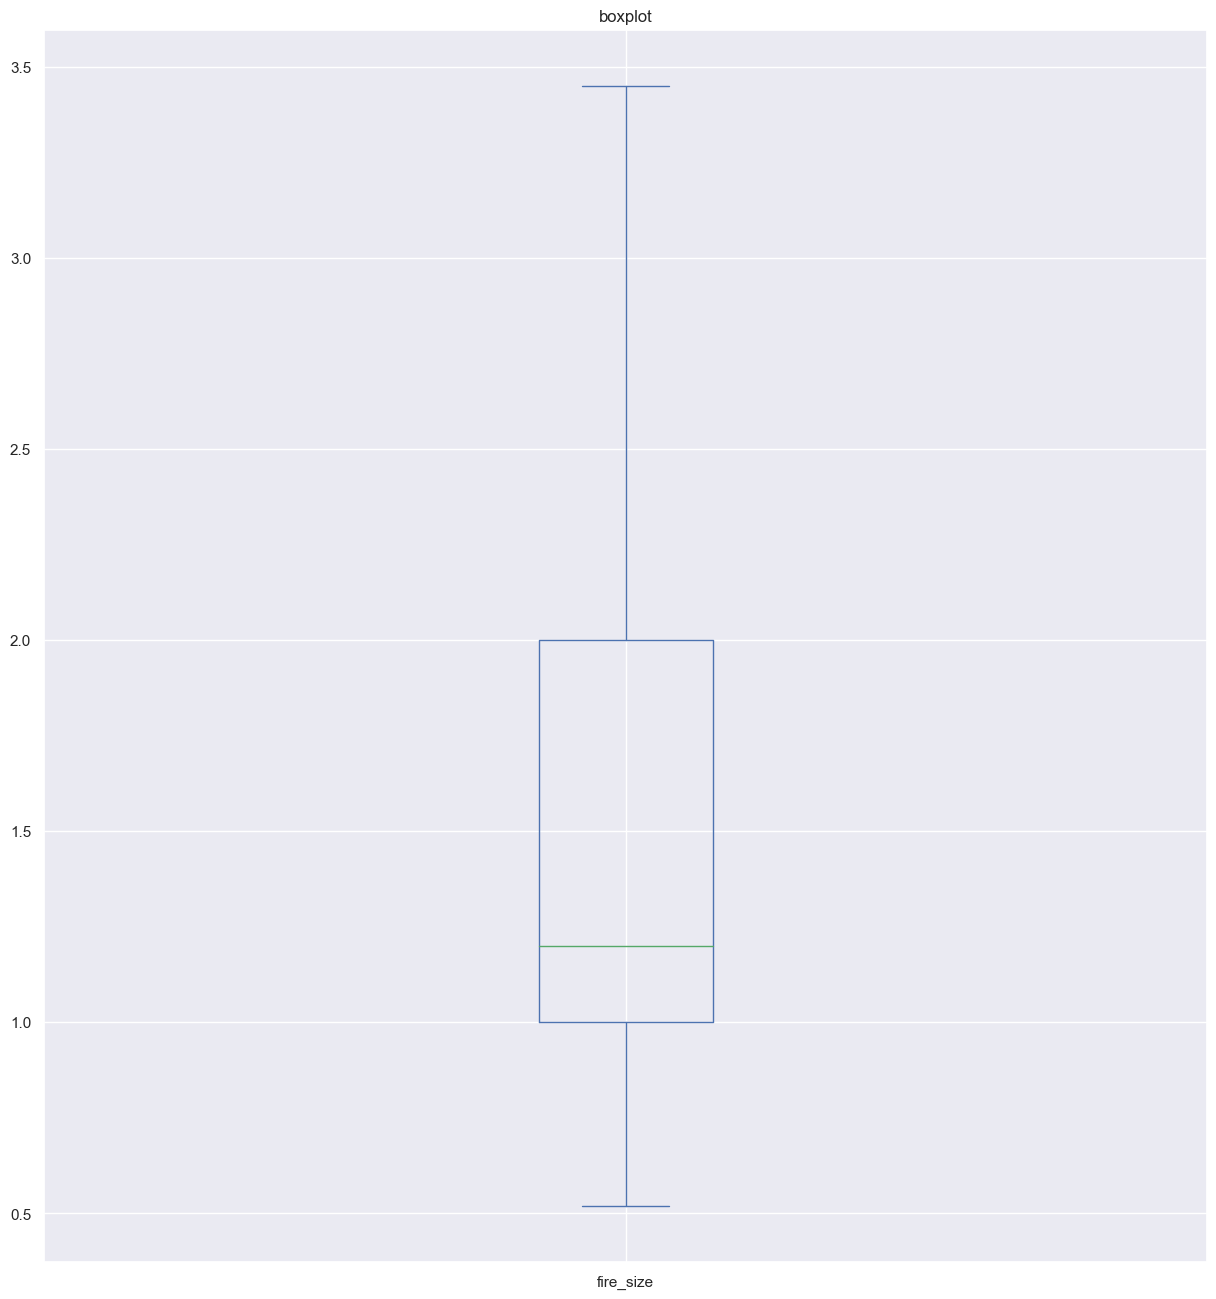

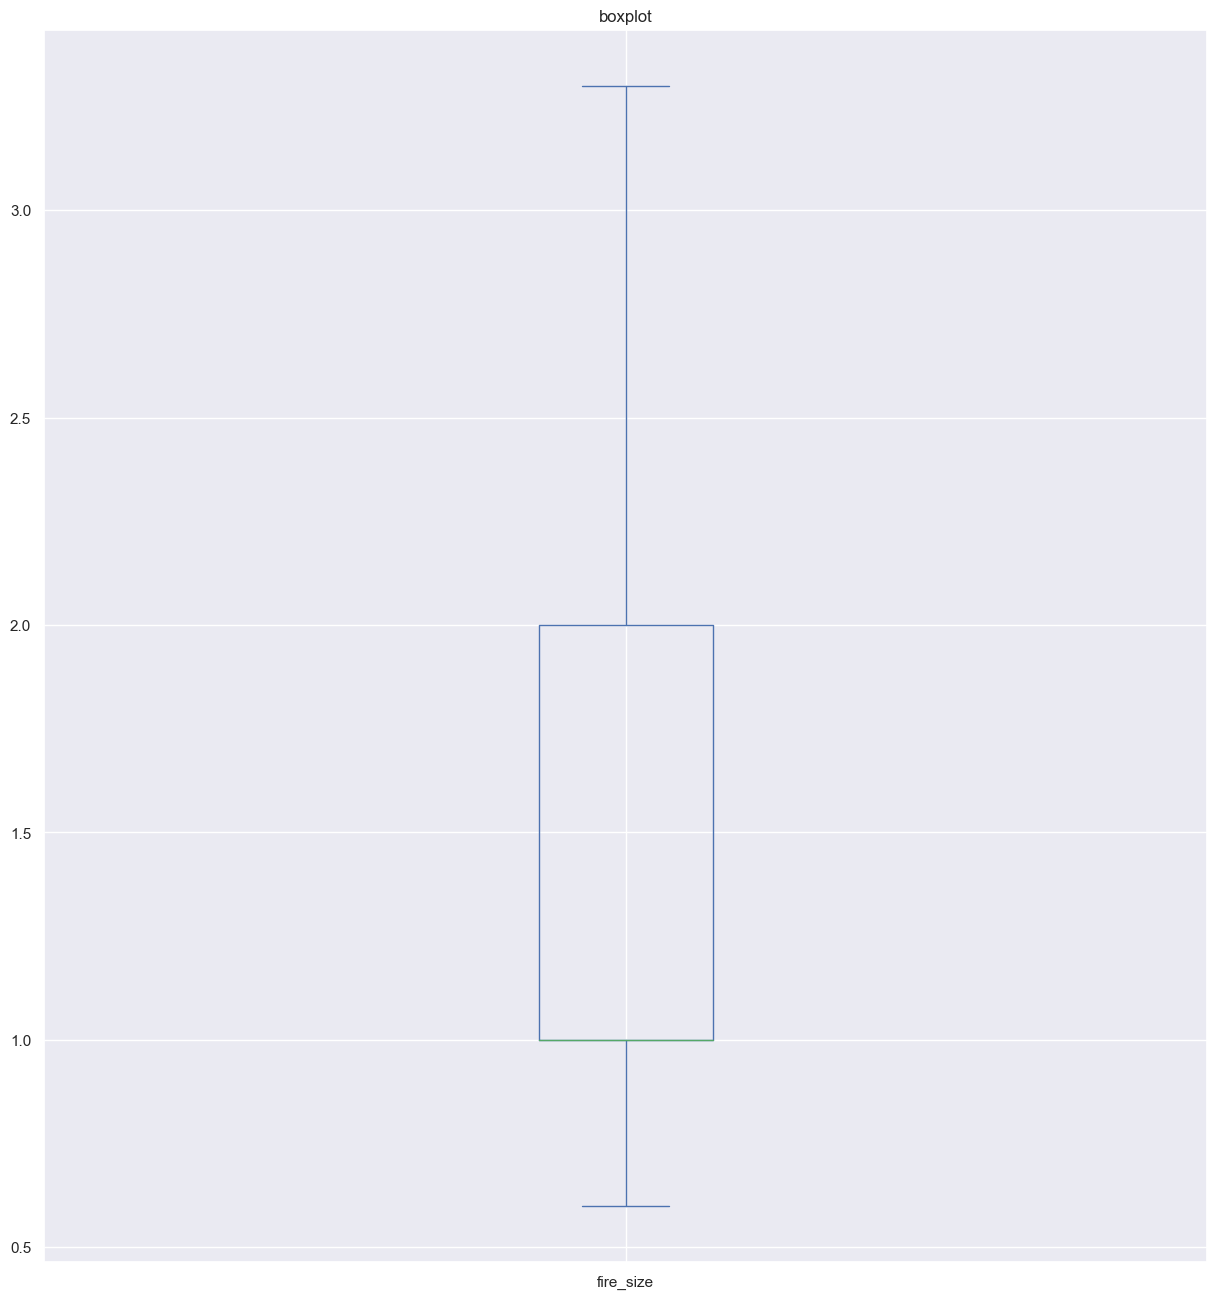

In [30]:
data1 = pd.DataFrame(np.random.rand(17,3), columns=['A','B','C']).assign(Location=1)
data2 = pd.DataFrame(np.random.rand(17,3)+0.2, columns=['A','B','C']).assign(Location=2)
data3 = pd.DataFrame(np.random.rand(17,3)+0.4, columns=['A','B','C']).assign(Location=3)

cdf = pd.concat([data1, data2, data3])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Letter'])
print(mdf.head())


def createBoxPlots(df):
    #print(len(df.dfList))
    boxList=[]
    i=1
    for df_r in df.dfList:
        #if(i==7):
        #    i+=1
        #boxplot = df_r.boxplot(["fire_size"])
        #boxList.append(boxplot)
        #i+=1
     
    #data = pd.DataFrame({"BoxR1": df.df_r1.boxplot(["fire_size"]), "BoxR2": np.random.rand(10)})

        # Plot the dataframe
        ax = df_r["fire_size"].plot(kind='box', title='boxplot')

        # Display the plot
        plt.show()
"""
    cdf = pd.concat(boxList)
    mdf = pd.melt(cdf,id_vars['Location'],var_name=['fire_size'])
    ax = sns.boxplot(x="Location", y="value", hue="Letter", data=mdf)    
    plt.show()"""
createBoxPlots(df_adjusted_ByRegion)

In [31]:
def normalizeAllFeatures(featureColumns, df):
    result= df
    for df_r in result.dfList:
        for feature in featureColumns:
            max_value = df_r[feature].max()
            min_value = df_r[feature].min()
            print(min_value,max_value)
            df_r[feature] = (df_r[feature] - min_value) / (max_value - min_value)
            
            break
        #print(df_r[feature].unique())
        #break
normalizeAllFeatures(["fire_size"],df_adjusted_ByRegion)        
    

0.6 3.4
0.51 3.4
0.56 3.3
0.52 3.3
0.55 3.4
0.6 3.4
0.51 3.49
0.52 3.45
0.6 3.3


C:\Users\John\AppData\Local\Temp\ipykernel_12648\1707892683.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Save python object to file for other notebooks and models for prediction

In [32]:
import pickle
#filehandler = open("regionDfObject.obj", 'wb',encoding='utf-8') 
#pickle.dump(df_adjusted_ByRegion, filehandler)
def pickleAllRegionDf(df):
    
    for i in range(len(df.dfList)):
        df_r = df.dfList[i]
        regionNum=i+1
        if(regionNum>=7):
            regionNum +=1
        df_r.to_pickle(f'df_r{regionNum}.pkl')
pickleAllRegionDf(df_adjusted_ByRegion)

df_adjusted.to_pickle("df_ByRegion.pkl")

Get density distributions of each region, use as additional feature for classification on size and or location for improved accuracy. 

In [ ]:
print(

## Exploratory work for density distributions(ignore for now)

In [33]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
latlon

array([[-17.85   , -64.7    ],
       [-16.3333 , -67.8333 ],
       [-16.3    , -67.8833 ],
       ...,
       [ -0.3    , -78.4667 ],
       [  0.6    , -77.8167 ],
       [  4.96667, -75.3833 ]], dtype=float32)

In [34]:
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')
species

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
#from sklearn.datasets.species_distributions import construct_grids
from sklearn.datasets.species_distributions import construct_grids
from sklearn.datasets fetch_species_distributions import construct_grids
xgrid, ygrid = construct_grids(data)

SyntaxError: invalid syntax (2189708417.py, line 3)

In [ ]:
print(data)

In [ ]:
#for i in range(len(df_adjusted_ByRegion.dfList)):
   # dfTemp = df_adjusted_ByRegion.dfList[i]
   # dfTemp.plot(kind='scatter',x='longitude',y='latitude',color='coral',alpha=0.3)
    #plt.show()

In [ ]:
def addFireSizeLabel(df): 
    df =df.copy()
    print(df["fire_size"].min(),df["fire_size"].max())
    
    df["fire_size_Label"] = df.apply(lambda row: (1 if(row["fire_size"]<df["fire_size"].mean()) else 2 ),  axis=1)
    #print(df["fire_size_Label"])
    return df
#addFireSizeLabel(df_adjusted_ByRegion.dfList[0] )                                 

In [ ]:
from mpl_toolkits.basemap import Basemap
from sklearn.neighbors import KernelDensity
#from sklearn.datasets.species_distributions import construct_grids
def densityDistributionFireSize(df):
    for j in range(len(df.dfList)):
        dfTemp = addFireSizeLabel(df.dfList[j])
        print(dfTemp)
        print("sizeof region:", dfTemp.shape)
        regionNum = j+1
        if(j>=7):
            regionNum+=1
        print(f"For region {regionNum}")
        
        #creating plots
        fig, ax = plt.subplots(1, 2)
        fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
        fireSize = ['SmallFire', 'LargeFire']
        cmaps = ['Purples', 'Reds']
        
        x = dfTemp[["latitude","longitude"]]
        print("____________x below")
        print(x)
        print(x["latitude"].min(),x["latitude"].max())
        print(x["longitude"].min(),x["longitude"].max())
        print("size of x: ",x.shape)
        y = dfTemp["fire_size_Label"]
        print("size of y: ",y.size)
        for i, axi in enumerate(ax):
            axi.set_title(fireSize[i])
            # plot coastlines with basemap
            m = Basemap(projection='cyl', llcrnrlat=x["latitude"].min(),
                        urcrnrlat=x["latitude"].max(), llcrnrlon=x["longitude"].min(),
                        urcrnrlon=x["longitude"].max(), resolution='c', ax=axi)
            m.drawmapboundary(fill_color='#DDEEFF')
            m.drawcoastlines()
            m.drawcountries()


            #kernel
            # construct a spherical kernel density estimate of the distribution
            x =x.to_numpy()
            #y=y.to_numpy()
            
            kde = KernelDensity(bandwidth=0.03, metric='haversine')
            #boolList = np.array([True if ele==i+1 else False for ele in y ])
            #x_i = x[boolList]
            #print("ylist; ", boolList)
            #print("combo, ", x_i)
            #kde.fit(np.radians(x[boolList]))
        
        
        break
densityDistributionFireSize(df_adjusted_ByRegion)